# Quantization of CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo

In [30]:
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torchvision.datasets import CIFAR10
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchinfo import summary
import torch.nn.utils.prune as prune
import torch.nn.utils.prune as prune_utils
from sklearn.metrics import accuracy_score
import os


In [4]:
base_path = "/content/drive/My Drive/Colab Notebooks/Hardware_AI/CA3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LSQplus Quantization

In [5]:
class Quantize(torch.nn.Module):
    def __init__(self, n_bits, n_frac, sign=True):
        super(Quantize, self).__init__()
        self.n_bits = n_bits
        self.n_frac = n_frac
        i = self.n_bits - self.n_frac
        if sign:
            self.max = float(2 ** (i - 1) - 2 ** (-self.n_frac))
            self.min = float(-2 ** (i - 1))
        else:
            self.max = float(2 ** (i) - 2 ** (-self.n_frac))
            self.min = 0.0

    def forward(self, x):
        if torch.onnx.is_in_onnx_export():
            return x
        else:
            n = float(2 ** self.n_frac)
            xx = torch.floor(x * n) / n
            clipped = torch.clip(xx, self.min, self.max)
            return clipped

In [6]:
class Round(Function):
    @staticmethod
    def forward(self, input):
        sign = torch.sign(input)
        output = sign * torch.floor(torch.abs(input) + 0.5)
        return output

    @staticmethod
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [7]:
class ALSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, beta, g, Qn, Qp):
        ctx.save_for_backward(weight, alpha, beta)
        ctx.other = g, Qn, Qp
        w_q = Round.apply(torch.div((weight - beta), alpha).clamp(Qn, Qp))
        w_q = w_q * alpha + beta
        return w_q

    @staticmethod
    def backward(ctx, grad_weight):
        weight, alpha, beta = ctx.saved_tensors
        g, Qn, Qp = ctx.other
        q_w = (weight - beta) / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller -bigger
        grad_alpha = ((smaller * Qn + bigger * Qp +
            between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_beta = ((smaller + bigger) * grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, grad_beta, None, None, None

In [8]:
class WLSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, g, Qn, Qp, per_channel):
        ctx.save_for_backward(weight, alpha)
        ctx.other = g, Qn, Qp, per_channel
        if per_channel:
            sizes = weight.size()
            # weight = weight.contiguous().view(weight.size()[0], -1)
            weight = weight.view(weight.size()[0], -1)
            weight = torch.transpose(weight, 0, 1)
            alpha = torch.broadcast_to(alpha, weight.size())
            wq = Round.apply(torch.div(weight, alpha).clamp(Qn, Qp))
            w_q = wq * alpha
            w_q = torch.transpose(w_q, 0, 1)
            # w_q = w_q.contiguous().view(sizes)
            w_q = w_q.view(sizes)
            wq = torch.transpose(wq, 0, 1).view(sizes)
        else:
            wq = Round.apply(torch.div(weight, alpha).clamp(Qn, Qp))
            w_q = wq * alpha
        return w_q, wq.detach()

    @staticmethod
    def backward(ctx, grad_weight, gwq):
        weight, alpha = ctx.saved_tensors
        g, Qn, Qp, per_channel = ctx.other
        if per_channel:
            sizes = weight.size()
            # weight = weight.contiguous().view(weight.size()[0], -1)
            weight = weight.view(weight.size()[0], -1)
            weight = torch.transpose(weight, 0, 1)
            alpha = torch.broadcast_to(alpha, weight.size())
            q_w = weight / alpha
            q_w = torch.transpose(q_w, 0, 1)
            # q_w = q_w.contiguous().view(sizes)
            q_w = q_w.view(sizes)
        else:
            q_w = weight / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller -bigger
        if per_channel:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g)
            # grad_alpha = grad_alpha.contiguous().view(grad_alpha.size()[0], -1).sum(dim=1)
            grad_alpha = grad_alpha.view(grad_alpha.size()[0], -1).sum(dim=1)
        else:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, None, None, None, None

In [9]:
class LSQPlusActivationQuantizer(nn.Module):
    def __init__(self, a_bits, all_positive=False,batch_init = 20):
        super(LSQPlusActivationQuantizer, self).__init__()
        self.a_bits = nn.Parameter(torch.tensor(a_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            # unsigned activation is quantized to [0, 2^b-1]
            self.Qn = 0
            self.Qp = 2 ** a_bits - 1
        else:
            # signed weight/activation is quantized to [-2^(b-1), 2^(b-1)-1]
            self.Qn = - 2 ** (a_bits - 1)
            self.Qp = 2 ** (a_bits - 1) - 1
        self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.register_buffer('init_state', torch.zeros(1))

    def forward(self, activation):
        if self.training:
            if self.init_state==0:
                self.g.data = torch.tensor(1.0/math.sqrt(activation.numel() * self.Qp))
                mina = torch.min(activation.detach())
                self.s.data = (torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = mina - self.s.data *self.Qn
                self.init_state += 1
            elif self.init_state<self.batch_init:
                mina = torch.min(activation.detach())
                self.s.data = self.s.data*0.9 + 0.1*(torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = self.s.data*0.9 + 0.1* (mina - self.s.data * self.Qn)
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.a_bits.item() == 32:
            q_a = activation
        elif self.a_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.a_bits.item() != 1
        else:
            q_a = ALSQPlus.apply(activation, self.s, self.beta, self.g, self.Qn, self.Qp)
        return q_a

In [10]:
class LSQPlusWeightQuantizer(nn.Module):
    def __init__(self, w_bits, all_positive=False, per_channel=False, batch_init = 20, shape=(1,), saved=True):
        super(LSQPlusWeightQuantizer, self).__init__()
        self.w_bits = nn.Parameter(torch.tensor(w_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            # unsigned activation is quantized to [0, 2^b-1]
            self.Qn = 0
            self.Qp = 2 ** w_bits - 1
        else:
            # signed weight/activation is quantized to [-2^(b-1), 2^(b-1)-1]
            self.Qn = - 2 ** (w_bits - 1)
            self.Qp = 2 ** (w_bits - 1) - 1
        self.per_channel = per_channel
        self.register_buffer('init_state', torch.zeros(1))
        if not per_channel:
           self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        else:
            self.s = torch.nn.Parameter(torch.ones(shape[0]), requires_grad=True)

        self.saved = saved
        if saved:
            self.wq = torch.nn.Parameter(torch.ones(shape), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)

    def forward(self, weight):
        '''
        For this work, each layer of weights and each layer of activations has a distinct step size, represented
as an fp32 value, initialized to 2h|v|i/√OP , computed on either the initial weights values or the first
batch of activations, respectively
        '''
        if self.training:
            if self.init_state==0:
                self.div = 2**self.w_bits.item()-1
                self.g.data = torch.tensor(1.0/math.sqrt(weight.numel() * self.Qp))
                if self.per_channel:
                    # weight_tmp = weight.detach().contiguous().view(weight.size()[0], -1)
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = max([torch.abs(mean-3*std), torch.abs(mean + 3*std)])/self.div
                self.init_state += 1
            elif self.init_state<self.batch_init:
                self.div = 2**self.w_bits.item()-1
                if self.per_channel:
                    # weight_tmp = weight.detach().contiguous().view(weight.size()[0], -1)
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = v*0.9 + 0.1*v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = self.s.data*0.9 + 0.1*max([torch.abs(mean-3*std), torch.abs(mean + 3*std)])/self.div
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.w_bits.item() == 32:
            w_q = weight
        elif self.w_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.w_bits.item() != 1
        else:
            if self.saved:
                w_q, self.wq.data = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)
            else:
                w_q, _ = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)

        return w_q

## Part1:

In [16]:
class QuantConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,
                 w_bits=8, a_bits=8, per_channel=True, all_positive=False):
        # Initialize base Conv2d layer
        super(QuantConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

        self.weight_quantizer = LSQPlusWeightQuantizer(
            w_bits=w_bits,
            all_positive=all_positive,
            per_channel=per_channel,
            shape=self.weight.shape
        )
        self.activation_quantizer = LSQPlusActivationQuantizer(
            a_bits=a_bits,
            all_positive=all_positive
        )

    def forward(self, x):
        quantized_weight = self.weight_quantizer(self.weight)

        output = F.conv2d(x, quantized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

        output = self.activation_quantizer(output)

        return output

In [17]:
class QuantLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, w_bits=8, a_bits=8, per_channel=True, all_positive=False):
        # Initialize base Linear layer
        super(QuantLinear, self).__init__(in_features, out_features, bias)

        self.weight_quantizer = LSQPlusWeightQuantizer(
            w_bits=w_bits,
            all_positive=all_positive,
            per_channel=per_channel,
            shape=self.weight.shape
        )
        self.activation_quantizer = LSQPlusActivationQuantizer(
            a_bits=a_bits,
            all_positive=all_positive
        )

    def forward(self, x):
        quantized_weight = self.weight_quantizer(self.weight)

        output = F.linear(x, quantized_weight, self.bias)

        output = self.activation_quantizer(output)

        return output

## Part2:

In [18]:
def prepare(model, w_bits=8, a_bits=8):
    model = copy.deepcopy(model)

    def replace_layers(module):
        for name, child in list(module.named_children()):
            if isinstance(child, nn.Conv2d):
                quant_conv = QuantConv2d(
                    in_channels=child.in_channels,
                    out_channels=child.out_channels,
                    kernel_size=child.kernel_size,
                    stride=child.stride,
                    padding=child.padding,
                    dilation=child.dilation,
                    groups=child.groups,
                    bias=(child.bias is not None),
                    w_bits=w_bits,
                    a_bits=a_bits,
                    per_channel=True,
                    all_positive=False
                )
                quant_conv.weight.data = child.weight.data.clone()
                if child.bias is not None:
                    quant_conv.bias.data = child.bias.data.clone()
                setattr(module, name, quant_conv)

            elif isinstance(child, nn.Linear):
                quant_linear = QuantLinear(
                    in_features=child.in_features,
                    out_features=child.out_features,
                    bias=(child.bias is not None),
                    w_bits=w_bits,
                    a_bits=a_bits,
                    per_channel=True,
                    all_positive=False
                )
                quant_linear.weight.data = child.weight.data.clone()
                if child.bias is not None:
                    quant_linear.bias.data = child.bias.data.clone()
                setattr(module, name, quant_linear)

            else:
                replace_layers(child)

    replace_layers(model)
    return model


## Part3: Quantize base model to 8 bit:

### Load Data set

In [14]:
trainset_raw = CIFAR10(root= base_path+'/train', train=True, download=True)

testset_raw = CIFAR10(root= base_path +'/test', train=False, download=True)

In [15]:
imgs = torch.stack([torch.tensor(np.array(img)).permute(2, 0, 1) / 255.0 for img, _ in trainset_raw], dim=0)

mean = imgs.mean(dim=(0, 2, 3))
std = imgs.std(dim=(0, 2, 3))

print(f"Mean: {mean}")
print(f"Std:  {std}")

Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [19]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_val_ratio = 0.9

train_size = int(train_val_ratio * len(trainset_raw))
val_size = len(trainset_raw) - train_size
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(trainset_raw, [train_size, val_size], generator=generator)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform

testset = datasets.CIFAR10(root=base_path + '/test', train=False, download=True, transform=val_test_transform)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Train samples: 45000
Validation samples: 5000
Test samples: 10000


In [20]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [21]:
def train_model(model, train_loader, val_loader, lr = 0.001, num_epochs=50, patience=7, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    best_model_state = None
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / total
        val_acc = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(avg_val_loss)

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


In [22]:
def evaluate(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)

### Base Model:

In [23]:
model = CNNModel(num_classes=10)
model.load_state_dict(torch.load(base_path + "/cnn_model.pth", map_location=torch.device(device)))


<All keys matched successfully>

In [ ]:
base_acc = evaluate(model, test_loader, device=device)
print(f"Base model accuracy: {base_acc:.4f}")


Base model accuracy: 0.8844


### Quantize 8 bit

In [ ]:
quantized8_model = prepare(model, w_bits=8, a_bits=8)

### Retraining the model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.4103 | Val Loss: 0.5326 | Train Acc: 0.8588 | Val Acc: 0.8332
Epoch 2/20 | Train Loss: 0.2719 | Val Loss: 0.4754 | Train Acc: 0.9009 | Val Acc: 0.8484
Epoch 3/20 | Train Loss: 0.2315 | Val Loss: 0.4675 | Train Acc: 0.9164 | Val Acc: 0.8492
Epoch 4/20 | Train Loss: 0.2165 | Val Loss: 0.4818 | Train Acc: 0.9228 | Val Acc: 0.8512
Epoch 5/20 | Train Loss: 0.2016 | Val Loss: 0.4556 | Train Acc: 0.9282 | Val Acc: 0.8604
Epoch 6/20 | Train Loss: 0.1880 | Val Loss: 0.4829 | Train Acc: 0.9324 | Val Acc: 0.8524
Epoch 7/20 | Train Loss: 0.1801 | Val Loss: 0.5039 | Train Acc: 0.9361 | Val Acc: 0.8442
Epoch 8/20 | Train Loss: 0.1687 | Val Loss: 0.4753 | Train Acc: 0.9394 | Val Acc: 0.8556
Epoch 9/20 | Train Loss: 0.1629 | Val Loss: 0.4580 | Train Acc: 0.9428 | Val Acc: 0.8596
Epoch 10/20 | Train Loss: 0.1366 | Val Loss: 0.4562 | Train Acc: 0.9522 | Val Acc: 0.8584
Epoch 11/20 | Train Loss: 0.1284 | Val Loss: 0.4434 | Train Acc: 0.9555 | Val Acc: 0.8622
Epoch 12/20 | Train

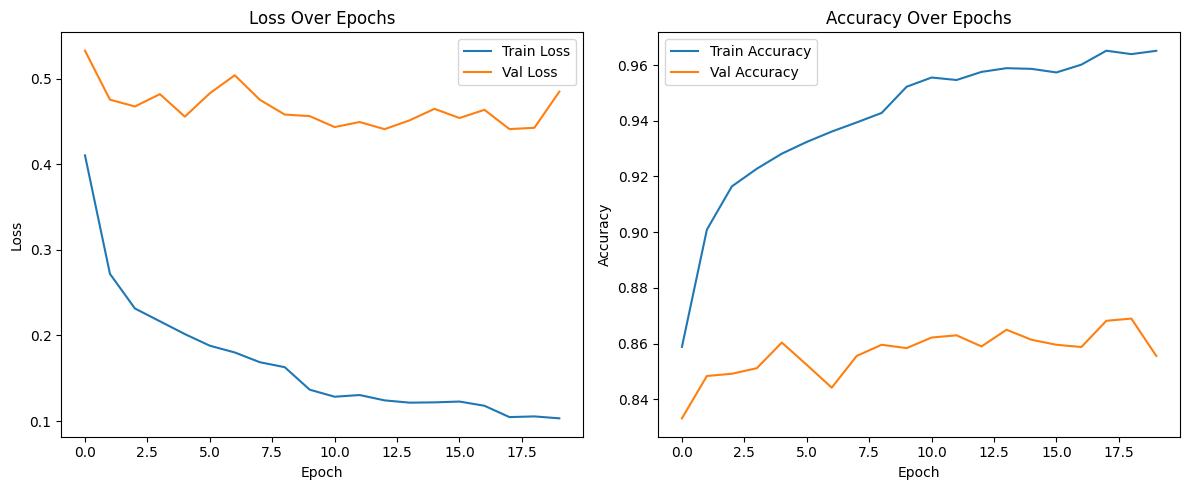

In [ ]:
quantized8_model = train_model(quantized8_model, train_loader, val_loader, lr=0.001, num_epochs=20, device=device)


In [ ]:
quant8_acc = evaluate(quantized8_model, test_loader, device=device)
print(f"Quantized model (8 bit) accuracy after fine-tuning: {quant8_acc:.4f}")

Quantized model (8 bit) accuracy after fine-tuning: 0.8591


In [ ]:
torch.save(quantized8_model.state_dict(), base_path + "/cnn_model_quantized8.pth")


In [ ]:
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Dropout: 2-8                      [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]          256
│    └─ReLU: 2-11                        [1, 128, 16, 16]          --
│

In [ ]:
summary(quantized8_model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
CNNModel                                           [1, 10]                   --
├─Sequential: 1-1                                  [1, 256, 4, 4]            --
│    └─QuantConv2d: 2-1                            [1, 64, 32, 32]           1,792
│    │    └─LSQPlusWeightQuantizer: 3-1            [64, 3, 3, 3]             1,794
│    │    └─LSQPlusActivationQuantizer: 3-2        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-2                            [1, 64, 32, 32]           128
│    └─ReLU: 2-3                                   [1, 64, 32, 32]           --
│    └─QuantConv2d: 2-4                            [1, 64, 32, 32]           36,928
│    │    └─LSQPlusWeightQuantizer: 3-3            [64, 64, 3, 3]            36,930
│    │    └─LSQPlusActivationQuantizer: 3-4        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-5                            [1, 64, 32, 32]           128
│    └─ReLU: 2-6     

In [24]:
def report_model_params(model):
    total_params = 0
    total_zeros = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_elements = param.numel()
            num_zeros = torch.sum(param == 0).item()
            total_params += num_elements
            total_zeros += num_zeros
            print(f"{name:<30} | Shape: {tuple(param.shape)} | Total: {num_elements} | Zeros: {num_zeros}")

    total_nonzeros = total_params - total_zeros
    sparsity = 100.0 * total_zeros / total_params

    print("\n Model Summary")
    print(f" Total parameters:    {total_params:,}")
    print(f" Zero parameters:     {total_zeros:,}")
    print(f" Non-zero parameters: {total_nonzeros:,}")
    print(f" Sparsity:            {sparsity:.2f}%")

In [ ]:
report_model_params(quantized8_model)

features.0.weight              | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 0
features.0.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.wq | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 1415
features.0.weight_quantizer.g  | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.s | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.beta | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.g | Shape: () | Total: 1 | Zeros: 0
features.1.weight              | Shape: (64,) | Total: 64 | Zeros: 0
features.1.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight              | Shape: (64, 64, 3, 3) | Total: 36864 | Zeros: 0
features.3.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.wq | Shape: (64, 64, 3, 3) | Total: 36864 | 

## Part4: Quantize to 6 and 4 bits

### 6 bit:

In [ ]:
quantized6_model = prepare(model, w_bits=6, a_bits=6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.4378 | Val Loss: 0.5451 | Train Acc: 0.8496 | Val Acc: 0.8288
Epoch 2/20 | Train Loss: 0.2872 | Val Loss: 0.5294 | Train Acc: 0.8980 | Val Acc: 0.8374
Epoch 3/20 | Train Loss: 0.2493 | Val Loss: 0.4926 | Train Acc: 0.9095 | Val Acc: 0.8504
Epoch 4/20 | Train Loss: 0.2291 | Val Loss: 0.4792 | Train Acc: 0.9186 | Val Acc: 0.8526
Epoch 5/20 | Train Loss: 0.2064 | Val Loss: 0.4685 | Train Acc: 0.9254 | Val Acc: 0.8502
Epoch 6/20 | Train Loss: 0.1917 | Val Loss: 0.4588 | Train Acc: 0.9302 | Val Acc: 0.8570
Epoch 7/20 | Train Loss: 0.1856 | Val Loss: 0.4442 | Train Acc: 0.9340 | Val Acc: 0.8626
Epoch 8/20 | Train Loss: 0.1751 | Val Loss: 0.4417 | Train Acc: 0.9383 | Val Acc: 0.8622
Epoch 9/20 | Train Loss: 0.1700 | Val Loss: 0.4750 | Train Acc: 0.9397 | Val Acc: 0.8592
Epoch 10/20 | Train Loss: 0.1647 | Val Loss: 0.4961 | Train Acc: 0.9408 | Val Acc: 0.8500
Epoch 11/20 | Train Loss: 0.1669 | Val Loss: 0.5127 | Train Acc: 0.9410 | Val Acc: 0.8474
Epoch 12/20 | Train

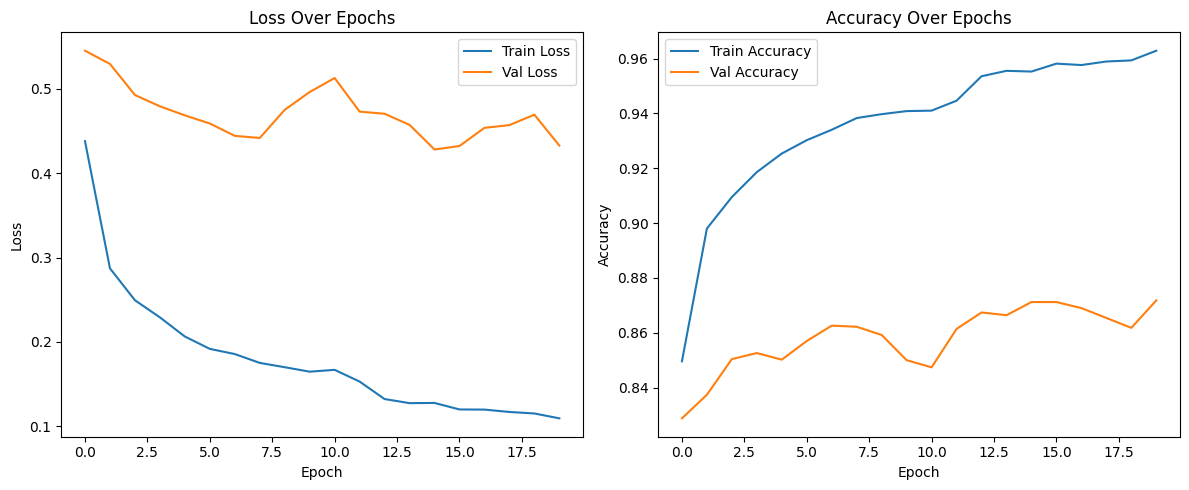

In [ ]:
quantized6_model = train_model(quantized6_model, train_loader, val_loader, lr=0.001, num_epochs=20, device=device)

In [ ]:
quant6_acc = evaluate(quantized6_model, test_loader, device=device)
print(f"Quantized model (6 bit) accuracy after fine-tuning: {quant6_acc:.4f}")

Quantized model (6 bit) accuracy after fine-tuning: 0.8657


In [ ]:
torch.save(quantized6_model.state_dict(), base_path + "/cnn_model_quantized6.pth")

In [ ]:
summary(quantized6_model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
CNNModel                                           [1, 10]                   --
├─Sequential: 1-1                                  [1, 256, 4, 4]            --
│    └─QuantConv2d: 2-1                            [1, 64, 32, 32]           1,792
│    │    └─LSQPlusWeightQuantizer: 3-1            [64, 3, 3, 3]             1,794
│    │    └─LSQPlusActivationQuantizer: 3-2        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-2                            [1, 64, 32, 32]           128
│    └─ReLU: 2-3                                   [1, 64, 32, 32]           --
│    └─QuantConv2d: 2-4                            [1, 64, 32, 32]           36,928
│    │    └─LSQPlusWeightQuantizer: 3-3            [64, 64, 3, 3]            36,930
│    │    └─LSQPlusActivationQuantizer: 3-4        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-5                            [1, 64, 32, 32]           128
│    └─ReLU: 2-6     

In [ ]:
report_model_params(quantized6_model)

features.0.weight              | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 0
features.0.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.wq | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 1425
features.0.weight_quantizer.g  | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.s | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.beta | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.g | Shape: () | Total: 1 | Zeros: 0
features.1.weight              | Shape: (64,) | Total: 64 | Zeros: 0
features.1.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight              | Shape: (64, 64, 3, 3) | Total: 36864 | Zeros: 0
features.3.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.wq | Shape: (64, 64, 3, 3) | Total: 36864 | 

### 4 bit:

In [ ]:
quantized4_model = prepare(model, w_bits=4, a_bits=4)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.7081 | Val Loss: 0.6402 | Train Acc: 0.7582 | Val Acc: 0.7906
Epoch 2/20 | Train Loss: 0.4815 | Val Loss: 0.6351 | Train Acc: 0.8223 | Val Acc: 0.8068
Epoch 3/20 | Train Loss: 0.4181 | Val Loss: 0.5686 | Train Acc: 0.8436 | Val Acc: 0.8180
Epoch 6/20 | Train Loss: 0.3230 | Val Loss: 0.5302 | Train Acc: 0.8774 | Val Acc: 0.8286
Epoch 7/20 | Train Loss: 0.3052 | Val Loss: 0.5241 | Train Acc: 0.8834 | Val Acc: 0.8404
Epoch 8/20 | Train Loss: 0.2893 | Val Loss: 0.5403 | Train Acc: 0.8900 | Val Acc: 0.8296
Epoch 9/20 | Train Loss: 0.2807 | Val Loss: 0.5206 | Train Acc: 0.8922 | Val Acc: 0.8380
Epoch 10/20 | Train Loss: 0.2549 | Val Loss: 0.4935 | Train Acc: 0.9029 | Val Acc: 0.8472
Epoch 11/20 | Train Loss: 0.2475 | Val Loss: 0.4815 | Train Acc: 0.9036 | Val Acc: 0.8508
Epoch 12/20 | Train Loss: 0.2365 | Val Loss: 0.4834 | Train Acc: 0.9088 | Val Acc: 0.8492
Epoch 13/20 | Train Loss: 0.2384 | Val Loss: 0.4941 | Train Acc: 0.9076 | Val Acc: 0.8436
Epoch 14/20 | Tra

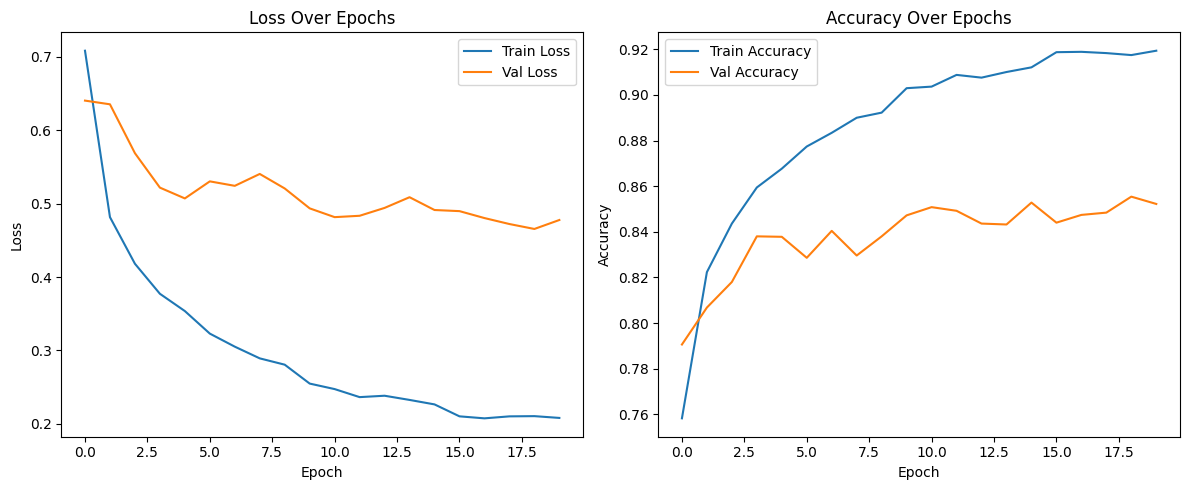

In [ ]:
quantized4_model = train_model(quantized4_model, train_loader, val_loader, lr=0.001, num_epochs=20, device=device)

In [ ]:
quant4_acc = evaluate(quantized4_model, test_loader, device=device)
print(f"Quantized model (4 bit) accuracy after fine-tuning: {quant4_acc:.4f}")

Quantized model (4 bit) accuracy after fine-tuning: 0.8448


In [ ]:
torch.save(quantized4_model.state_dict(), base_path + "/cnn_model_quantized4.pth")

In [ ]:
summary(quantized4_model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
CNNModel                                           [1, 10]                   --
├─Sequential: 1-1                                  [1, 256, 4, 4]            --
│    └─QuantConv2d: 2-1                            [1, 64, 32, 32]           1,792
│    │    └─LSQPlusWeightQuantizer: 3-1            [64, 3, 3, 3]             1,794
│    │    └─LSQPlusActivationQuantizer: 3-2        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-2                            [1, 64, 32, 32]           128
│    └─ReLU: 2-3                                   [1, 64, 32, 32]           --
│    └─QuantConv2d: 2-4                            [1, 64, 32, 32]           36,928
│    │    └─LSQPlusWeightQuantizer: 3-3            [64, 64, 3, 3]            36,930
│    │    └─LSQPlusActivationQuantizer: 3-4        [1, 64, 32, 32]           4
│    └─BatchNorm2d: 2-5                            [1, 64, 32, 32]           128
│    └─ReLU: 2-6     

In [ ]:
report_model_params(quantized4_model)

features.0.weight              | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 0
features.0.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.0.weight_quantizer.wq | Shape: (64, 3, 3, 3) | Total: 1728 | Zeros: 1330
features.0.weight_quantizer.g  | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.s | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.beta | Shape: () | Total: 1 | Zeros: 0
features.0.activation_quantizer.g | Shape: () | Total: 1 | Zeros: 0
features.1.weight              | Shape: (64,) | Total: 64 | Zeros: 0
features.1.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight              | Shape: (64, 64, 3, 3) | Total: 36864 | Zeros: 0
features.3.bias                | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.s  | Shape: (64,) | Total: 64 | Zeros: 0
features.3.weight_quantizer.wq | Shape: (64, 64, 3, 3) | Total: 36864 | 

In [ ]:
def report_sizes(model, label, bits):
    total_w = sum(p.numel() for n,p in model.named_parameters() if 'weight' in n)
    total_b = sum(p.numel() for n,p in model.named_parameters() if 'bias'   in n)
    bits_total = total_w * bits + total_b * 32
    size_mb = bits_total / 8 / 1024**2
    print(f"[{label}] Size with {bits}-bit weights: {size_mb:.2f} MB")


report_sizes(model,         "base (32-bit)", 32)
report_sizes(quantized8_model,  "8-bit QAT",     8)
report_sizes(quantized6_model,  "6-bit QAT",     6)
report_sizes(quantized4_model,  "4-bit QAT",     4)


[base (32-bit)] Size with 32-bit weights: 4.53 MB
[8-bit QAT] Size with 8-bit weights: 2.27 MB
[6-bit QAT] Size with 6-bit weights: 1.70 MB
[4-bit QAT] Size with 4-bit weights: 1.14 MB


## Part5: Quantizing Pruned models

In [25]:
def apply_unstructured_pruning(model, amount):
    model_copy = copy.deepcopy(model)
    for name, module in model_copy.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model_copy

def count_nonzero_param_size_MB(model):
    total_nonzero = 0
    for param in model.parameters():
        if param.requires_grad:
            total_nonzero += torch.count_nonzero(param).item()
    size_MB = total_nonzero * 4 / (1024 ** 2)
    return size_MB, total_nonzero


def evaluate(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)

In [26]:
def report_sizes_pruned(model, label, bits):
    total_w = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_w += param.nonzero().size(0)  # count non-zero weights

    total_b = sum(p.numel() for n, p in model.named_parameters() if 'bias' in n)

    bits_total = total_w * bits + total_b * 32
    size_mb = bits_total / 8 / 1024**2
    print(f"[{label}] Size with {bits}-bit quantized weights: {size_mb:.2f} MB")


### Unstructured Pruned models (One Shot)

#### 1: 20% Pruned

In [ ]:
amount=0.2
pruned_u20_model = apply_unstructured_pruning(model, amount)

In [ ]:
acc_u20 = evaluate(pruned_u20_model, test_loader)

In [ ]:
size_u20_MB, pruned_params_u20 = count_nonzero_param_size_MB(pruned_u20_model)

In [ ]:
print(f"Pruned {int(amount * 100)}% → Accuracy: {acc_u20 * 100:.2f}% | Size: {size_u20_MB:.2f} MB | Params: {pruned_params_u20}")

Pruned 20% → Accuracy: 88.31% | Size: 3.63 MB | Params: 951075


##### Quantize 8:

In [ ]:
quantized8_u20_model = prepare(pruned_u20_model, w_bits=8, a_bits=8)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4080 | Val Loss: 0.5063 | Train Acc: 0.8593 | Val Acc: 0.8420
Epoch 2/10 | Train Loss: 0.2687 | Val Loss: 0.4994 | Train Acc: 0.9035 | Val Acc: 0.8456
Epoch 3/10 | Train Loss: 0.2390 | Val Loss: 0.4803 | Train Acc: 0.9147 | Val Acc: 0.8556
Epoch 4/10 | Train Loss: 0.2131 | Val Loss: 0.5510 | Train Acc: 0.9243 | Val Acc: 0.8374
Epoch 5/10 | Train Loss: 0.2001 | Val Loss: 0.4426 | Train Acc: 0.9288 | Val Acc: 0.8612
Epoch 6/10 | Train Loss: 0.1903 | Val Loss: 0.4882 | Train Acc: 0.9320 | Val Acc: 0.8506
Epoch 7/10 | Train Loss: 0.1807 | Val Loss: 0.4816 | Train Acc: 0.9358 | Val Acc: 0.8546
Epoch 8/10 | Train Loss: 0.1664 | Val Loss: 0.5080 | Train Acc: 0.9413 | Val Acc: 0.8512
Epoch 9/10 | Train Loss: 0.1591 | Val Loss: 0.4648 | Train Acc: 0.9452 | Val Acc: 0.8584
Epoch 10/10 | Train Loss: 0.1359 | Val Loss: 0.4367 | Train Acc: 0.9531 | Val Acc: 0.8648


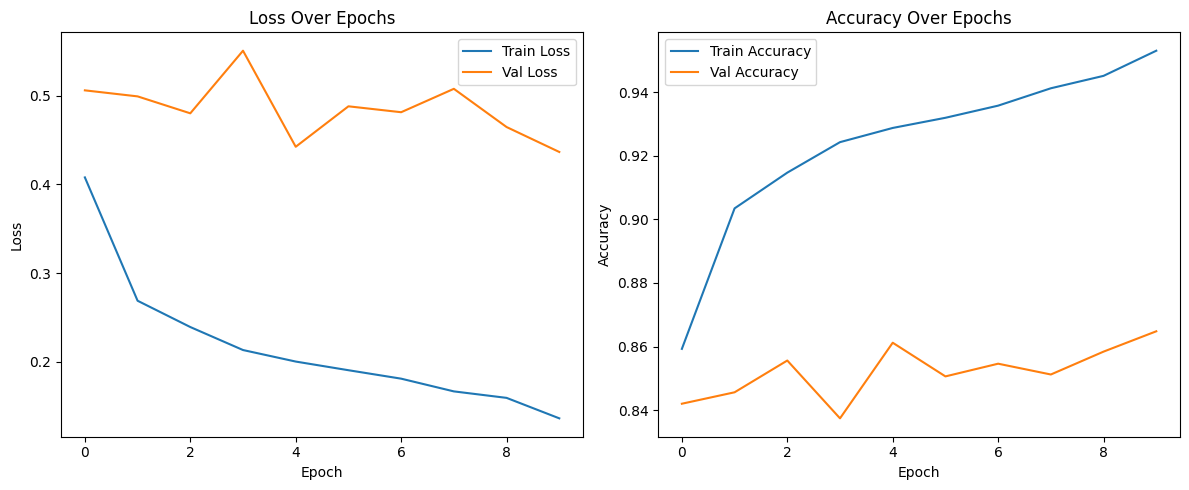

In [ ]:
quantized8_u20_model = train_model(quantized8_u20_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [ ]:
quant8_u20_acc = evaluate(quantized8_u20_model, test_loader, device=device)
print(f"Quantized unstructured 20% pruned model (8 bit) accuracy after fine-tuning: {quant8_u20_acc:.4f}")

Quantized unstructured 20% pruned model (8 bit) accuracy after fine-tuning: 0.8593


In [ ]:
torch.save(quantized8_u20_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_u20_quantized8.pth")

In [ ]:
report_sizes_pruned(quantized8_u20_model,  "8-bit QAT unstructured 20% pruned",     8)

[8-bit QAT unstructured 20% pruned] Size with 8-bit quantized weights: 1.35 MB


##### Quantize 6:

In [ ]:
quantized6_u20_model = prepare(pruned_u20_model, w_bits=6, a_bits=6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/14 | Train Loss: 0.4279 | Val Loss: 0.5598 | Train Acc: 0.8515 | Val Acc: 0.8298
Epoch 2/14 | Train Loss: 0.2803 | Val Loss: 0.5200 | Train Acc: 0.8994 | Val Acc: 0.8368
Epoch 3/14 | Train Loss: 0.2485 | Val Loss: 0.4902 | Train Acc: 0.9116 | Val Acc: 0.8484
Epoch 4/14 | Train Loss: 0.2302 | Val Loss: 0.5414 | Train Acc: 0.9173 | Val Acc: 0.8448
Epoch 5/14 | Train Loss: 0.2153 | Val Loss: 0.4958 | Train Acc: 0.9222 | Val Acc: 0.8506
Epoch 6/14 | Train Loss: 0.1938 | Val Loss: 0.5086 | Train Acc: 0.9308 | Val Acc: 0.8452
Epoch 7/14 | Train Loss: 0.1844 | Val Loss: 0.4896 | Train Acc: 0.9330 | Val Acc: 0.8556
Epoch 8/14 | Train Loss: 0.1801 | Val Loss: 0.4611 | Train Acc: 0.9364 | Val Acc: 0.8556
Epoch 9/14 | Train Loss: 0.1678 | Val Loss: 0.4761 | Train Acc: 0.9414 | Val Acc: 0.8560
Epoch 10/14 | Train Loss: 0.1611 | Val Loss: 0.4339 | Train Acc: 0.9418 | Val Acc: 0.8690
Epoch 11/14 | Train Loss: 0.1555 | Val Loss: 0.4687 | Train Acc: 0.9436 | Val Acc: 0.8596
Epoch 12/14 | Train

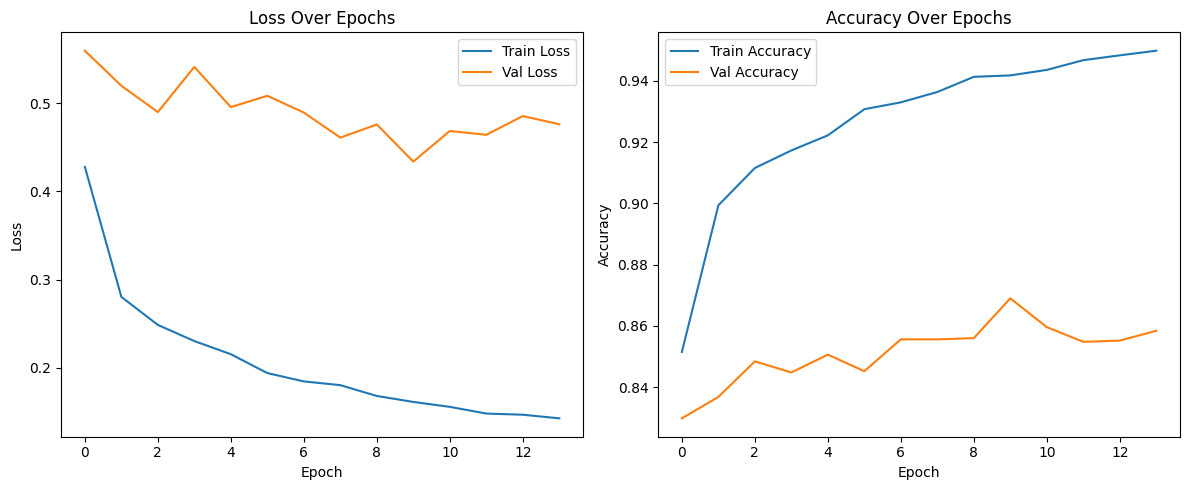

In [ ]:
quantized6_u20_model = train_model(quantized6_u20_model, train_loader, val_loader, lr=0.001, num_epochs=14, device=device)

In [ ]:
quant6_u20_acc = evaluate(quantized6_u20_model, test_loader, device=device)
print(f"Quantized unstructured 20% pruned model (6 bit) accuracy after fine-tuning: {quant6_u20_acc:.4f}")

Quantized unstructured 20% pruned model (6 bit) accuracy after fine-tuning: 0.8573


In [ ]:
torch.save(quantized6_u20_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_u20_quantized6.pth")

In [ ]:
report_sizes_pruned(quantized6_u20_model,  "6-bit QAT unstructured 20% pruned", 6)

[6-bit QAT unstructured 20% pruned] Size with 6-bit quantized weights: 1.02 MB


#### 2: 30% Pruned

In [ ]:
amount=0.3
pruned_u30_model = apply_unstructured_pruning(model, amount)

In [ ]:
acc_u30 = evaluate(pruned_u30_model, test_loader)

In [ ]:
size_u30_MB, pruned_params_u30 = count_nonzero_param_size_MB(pruned_u30_model)

In [ ]:
print(f"Pruned {int(amount * 100)}% → Accuracy: {acc_u30 * 100:.2f}% | Size: {size_u30_MB:.2f} MB | Params: {pruned_params_u30}")

Pruned 30% → Accuracy: 87.81% | Size: 3.18 MB | Params: 832529


##### Quantize 8:

In [ ]:
quantized8_u30_model = prepare(pruned_u30_model, w_bits=8, a_bits=8)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4011 | Val Loss: 0.5344 | Train Acc: 0.8604 | Val Acc: 0.8312
Epoch 2/10 | Train Loss: 0.2574 | Val Loss: 0.5094 | Train Acc: 0.9085 | Val Acc: 0.8410
Epoch 3/10 | Train Loss: 0.2384 | Val Loss: 0.4873 | Train Acc: 0.9168 | Val Acc: 0.8458
Epoch 4/10 | Train Loss: 0.2168 | Val Loss: 0.5124 | Train Acc: 0.9237 | Val Acc: 0.8438
Epoch 5/10 | Train Loss: 0.1967 | Val Loss: 0.4595 | Train Acc: 0.9290 | Val Acc: 0.8616
Epoch 6/10 | Train Loss: 0.1860 | Val Loss: 0.4552 | Train Acc: 0.9347 | Val Acc: 0.8640
Epoch 7/10 | Train Loss: 0.1744 | Val Loss: 0.4685 | Train Acc: 0.9392 | Val Acc: 0.8618
Epoch 8/10 | Train Loss: 0.1628 | Val Loss: 0.4614 | Train Acc: 0.9425 | Val Acc: 0.8632
Epoch 9/10 | Train Loss: 0.1606 | Val Loss: 0.4830 | Train Acc: 0.9426 | Val Acc: 0.8578
Epoch 10/10 | Train Loss: 0.1493 | Val Loss: 0.5060 | Train Acc: 0.9482 | Val Acc: 0.8536


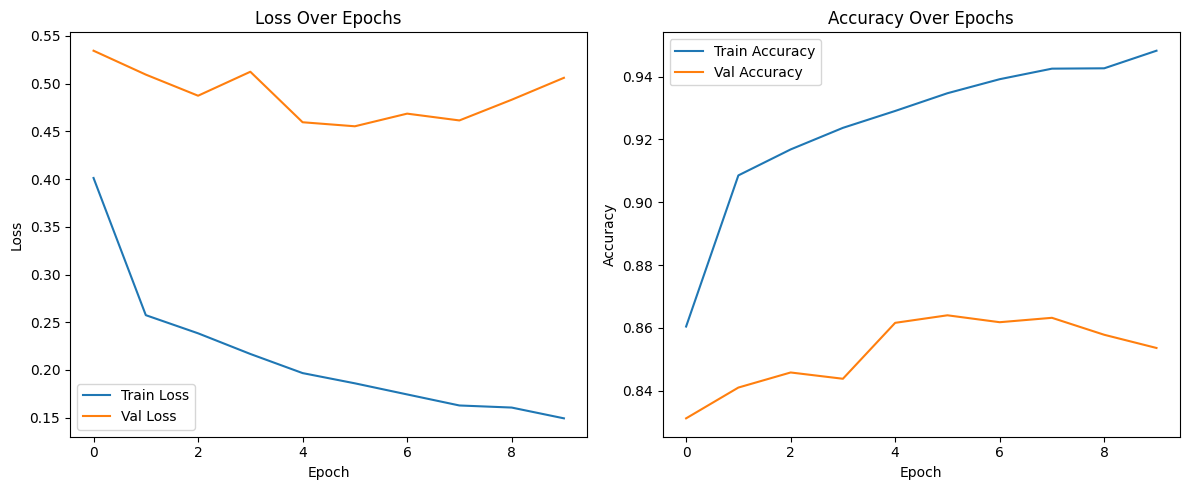

In [ ]:
quantized8_u30_model = train_model(quantized8_u30_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [ ]:
quant8_u30_acc = evaluate(quantized8_u30_model, test_loader, device=device)
print(f"Quantized unstructured 30% pruned model (8 bit) accuracy after fine-tuning: {quant8_u30_acc:.4f}")

Quantized unstructured 30% pruned model (8 bit) accuracy after fine-tuning: 0.8452


In [ ]:
torch.save(quantized8_u30_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_u30_quantized8.pth")

In [ ]:
report_sizes_pruned(quantized8_u30_model,  "8-bit QAT unstructured 30% pruned",8)

[8-bit QAT unstructured 30% pruned] Size with 8-bit quantized weights: 1.35 MB


##### Quantize 6:

In [ ]:
quantized6_u30_model = prepare(pruned_u30_model, w_bits=6, a_bits=6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4138 | Val Loss: 0.5126 | Train Acc: 0.8558 | Val Acc: 0.8398
Epoch 2/10 | Train Loss: 0.2809 | Val Loss: 0.5297 | Train Acc: 0.8987 | Val Acc: 0.8418
Epoch 3/10 | Train Loss: 0.2458 | Val Loss: 0.4941 | Train Acc: 0.9118 | Val Acc: 0.8432
Epoch 4/10 | Train Loss: 0.2217 | Val Loss: 0.4765 | Train Acc: 0.9198 | Val Acc: 0.8600
Epoch 5/10 | Train Loss: 0.2052 | Val Loss: 0.4708 | Train Acc: 0.9259 | Val Acc: 0.8528
Epoch 6/10 | Train Loss: 0.1934 | Val Loss: 0.4852 | Train Acc: 0.9314 | Val Acc: 0.8474
Epoch 7/10 | Train Loss: 0.1801 | Val Loss: 0.4764 | Train Acc: 0.9345 | Val Acc: 0.8528
Epoch 8/10 | Train Loss: 0.1750 | Val Loss: 0.4592 | Train Acc: 0.9364 | Val Acc: 0.8608
Epoch 9/10 | Train Loss: 0.1645 | Val Loss: 0.4689 | Train Acc: 0.9430 | Val Acc: 0.8546
Epoch 10/10 | Train Loss: 0.1580 | Val Loss: 0.4613 | Train Acc: 0.9433 | Val Acc: 0.8576


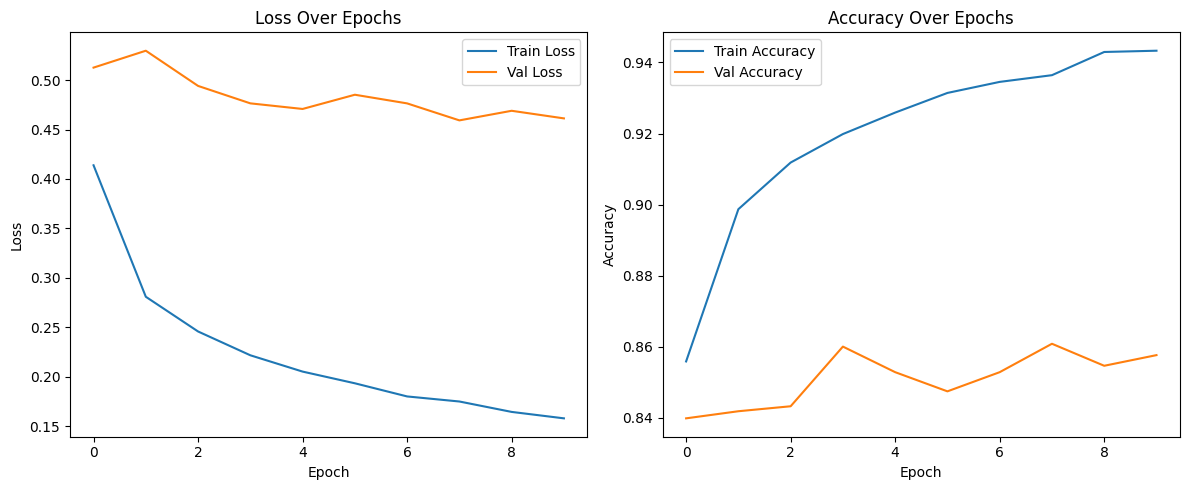

In [ ]:
quantized6_u30_model = train_model(quantized6_u30_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [ ]:
quant6_u30_acc = evaluate(quantized6_u30_model, test_loader, device=device)
print(f"Quantized unstructured 30% pruned model (6 bit) accuracy after fine-tuning: {quant6_u30_acc:.4f}")

Quantized unstructured 30% pruned model (6 bit) accuracy after fine-tuning: 0.8592


In [ ]:
torch.save(quantized6_u30_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_u30_quantized6.pth")

In [ ]:
report_sizes_pruned(quantized6_u30_model,  "6-bit QAT unstructured 30% pruned", 6)

[6-bit QAT unstructured 30% pruned] Size with 6-bit quantized weights: 1.02 MB


### Unstructured Pruned models (Step by Step)

In [27]:
def apply_incremental_pruning(model, amount):
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)

In [28]:
def count_nonzero_param_size_step(model):
    total_nonzero = 0
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            if hasattr(module, 'weight_mask'):
                total_nonzero += torch.count_nonzero(module.weight_mask).item()
            else:
                total_nonzero += torch.count_nonzero(module.weight).item()
    size_MB = total_nonzero * 4 / (1024 ** 2)
    return size_MB, total_nonzero


In [32]:
model_sbs = CNNModel(num_classes=10)
model_sbs.load_state_dict(torch.load(base_path + "/cnn_model.pth", map_location=torch.device(device)))

<All keys matched successfully>


Applying 20% cumulative pruning:
Epoch 1/10 | Train Loss: 0.0640 | Val Loss: 0.5091 | Train Acc: 0.9799 | Val Acc: 0.8636
Epoch 2/10 | Train Loss: 0.0850 | Val Loss: 0.5084 | Train Acc: 0.9718 | Val Acc: 0.8630
Epoch 3/10 | Train Loss: 0.0907 | Val Loss: 0.5121 | Train Acc: 0.9687 | Val Acc: 0.8480
Epoch 4/10 | Train Loss: 0.0803 | Val Loss: 0.4902 | Train Acc: 0.9733 | Val Acc: 0.8606
Epoch 5/10 | Train Loss: 0.0754 | Val Loss: 0.4814 | Train Acc: 0.9746 | Val Acc: 0.8666
Epoch 6/10 | Train Loss: 0.0769 | Val Loss: 0.4937 | Train Acc: 0.9739 | Val Acc: 0.8600
Epoch 7/10 | Train Loss: 0.0720 | Val Loss: 0.4575 | Train Acc: 0.9764 | Val Acc: 0.8696
Epoch 8/10 | Train Loss: 0.0647 | Val Loss: 0.4609 | Train Acc: 0.9788 | Val Acc: 0.8722
Epoch 9/10 | Train Loss: 0.0648 | Val Loss: 0.4490 | Train Acc: 0.9789 | Val Acc: 0.8686
Epoch 10/10 | Train Loss: 0.0684 | Val Loss: 0.4788 | Train Acc: 0.9778 | Val Acc: 0.8718


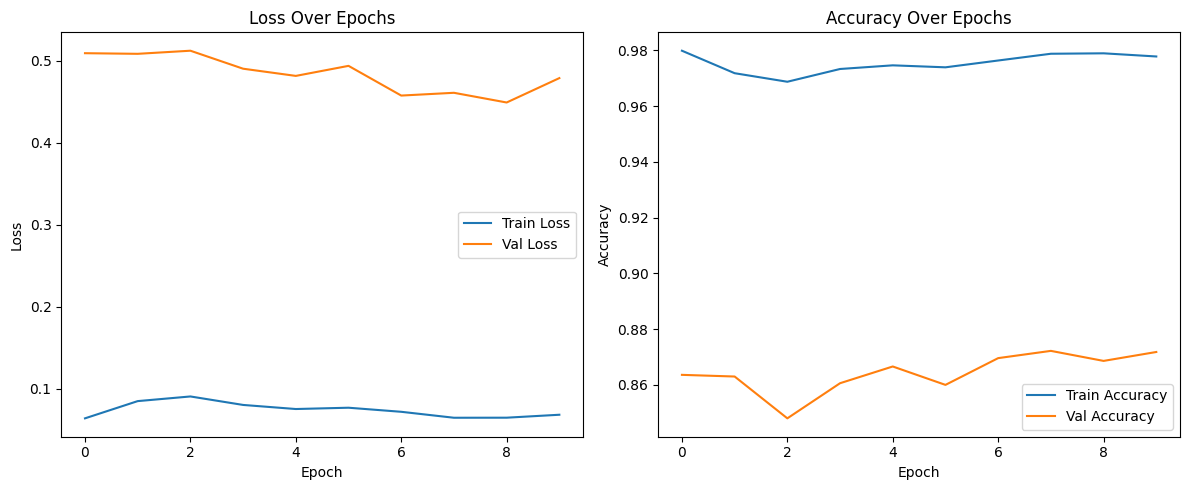

Pruned 20% : Accuracy: 86.16% | Size: 4.07 MB | Params: 1066925

Applying 30% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0526 | Val Loss: 0.4388 | Train Acc: 0.9836 | Val Acc: 0.8732
Epoch 2/10 | Train Loss: 0.0502 | Val Loss: 0.4363 | Train Acc: 0.9841 | Val Acc: 0.8748
Epoch 3/10 | Train Loss: 0.0498 | Val Loss: 0.4818 | Train Acc: 0.9844 | Val Acc: 0.8664
Epoch 4/10 | Train Loss: 0.0474 | Val Loss: 0.4823 | Train Acc: 0.9858 | Val Acc: 0.8720
Epoch 5/10 | Train Loss: 0.0472 | Val Loss: 0.4605 | Train Acc: 0.9852 | Val Acc: 0.8738
Early stopping triggered.


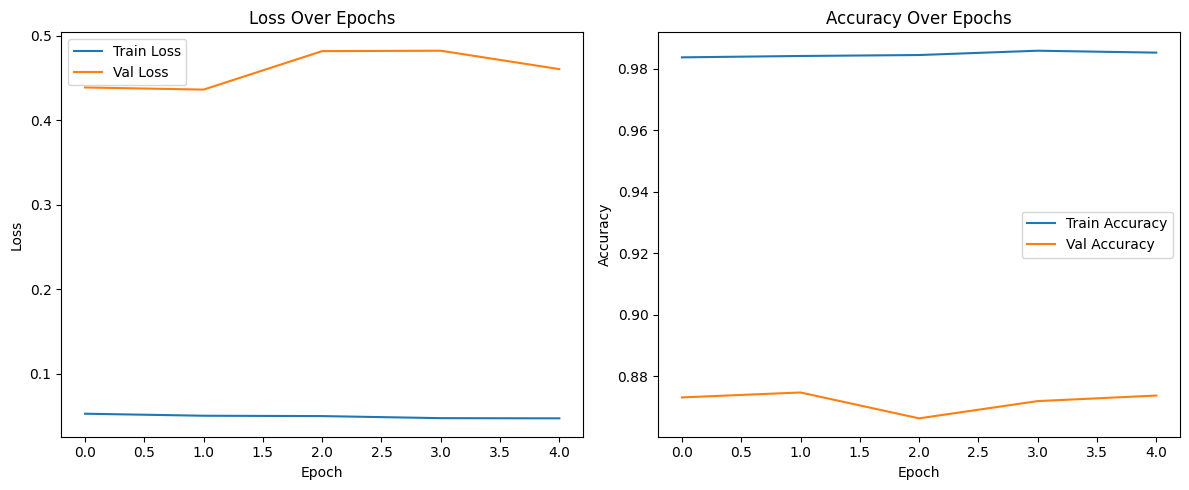

Pruned 30% : Accuracy: 86.87% | Size: 3.66 MB | Params: 960232

Applying 40% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0400 | Val Loss: 0.4368 | Train Acc: 0.9884 | Val Acc: 0.8790
Epoch 2/10 | Train Loss: 0.0401 | Val Loss: 0.4298 | Train Acc: 0.9879 | Val Acc: 0.8784
Epoch 3/10 | Train Loss: 0.0376 | Val Loss: 0.4543 | Train Acc: 0.9889 | Val Acc: 0.8744
Epoch 4/10 | Train Loss: 0.0379 | Val Loss: 0.4781 | Train Acc: 0.9888 | Val Acc: 0.8752
Epoch 5/10 | Train Loss: 0.0409 | Val Loss: 0.4684 | Train Acc: 0.9880 | Val Acc: 0.8758
Early stopping triggered.


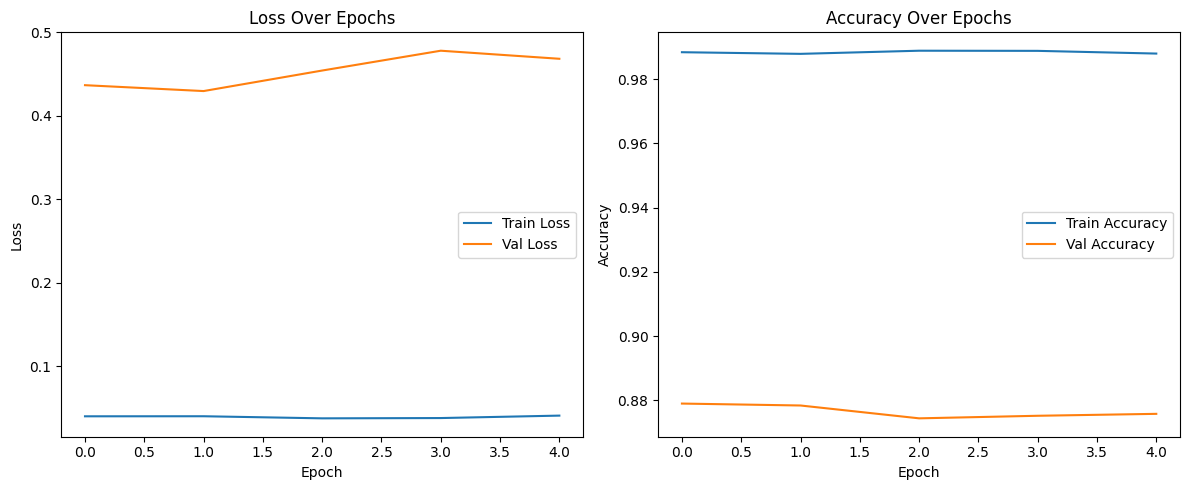

Pruned 40% : Accuracy: 87.10% | Size: 3.30 MB | Params: 864208

Applying 50% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0349 | Val Loss: 0.4252 | Train Acc: 0.9903 | Val Acc: 0.8830
Epoch 2/10 | Train Loss: 0.0364 | Val Loss: 0.4728 | Train Acc: 0.9895 | Val Acc: 0.8738
Epoch 3/10 | Train Loss: 0.0332 | Val Loss: 0.4369 | Train Acc: 0.9903 | Val Acc: 0.8768
Epoch 4/10 | Train Loss: 0.0356 | Val Loss: 0.4572 | Train Acc: 0.9894 | Val Acc: 0.8796
Early stopping triggered.


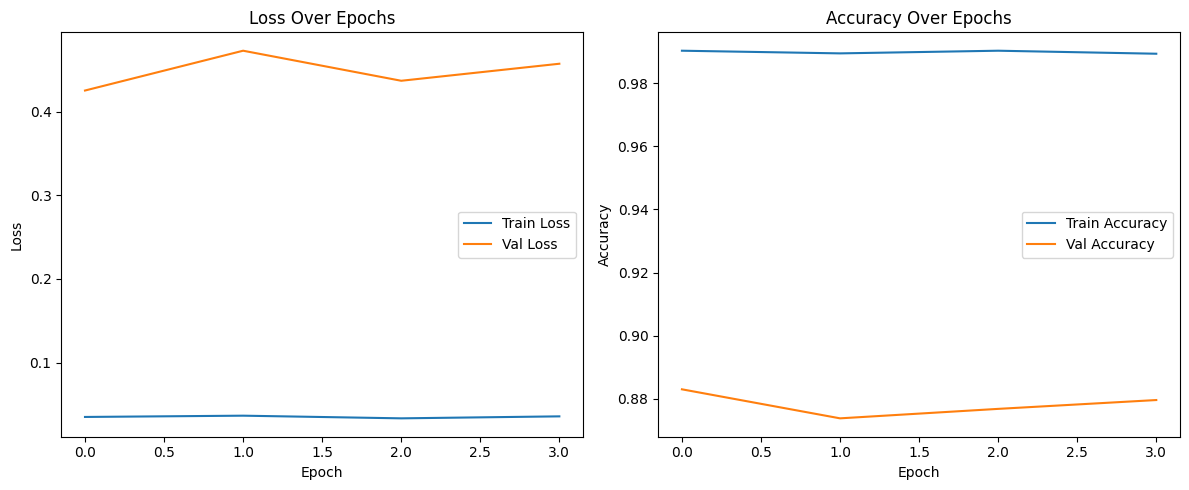

Pruned 50% : Accuracy: 87.22% | Size: 2.97 MB | Params: 777787

Applying 60% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0384 | Val Loss: 0.4115 | Train Acc: 0.9886 | Val Acc: 0.8858
Epoch 2/10 | Train Loss: 0.0314 | Val Loss: 0.4464 | Train Acc: 0.9911 | Val Acc: 0.8804
Epoch 3/10 | Train Loss: 0.0312 | Val Loss: 0.4402 | Train Acc: 0.9916 | Val Acc: 0.8806
Epoch 4/10 | Train Loss: 0.0354 | Val Loss: 0.4482 | Train Acc: 0.9901 | Val Acc: 0.8816
Early stopping triggered.


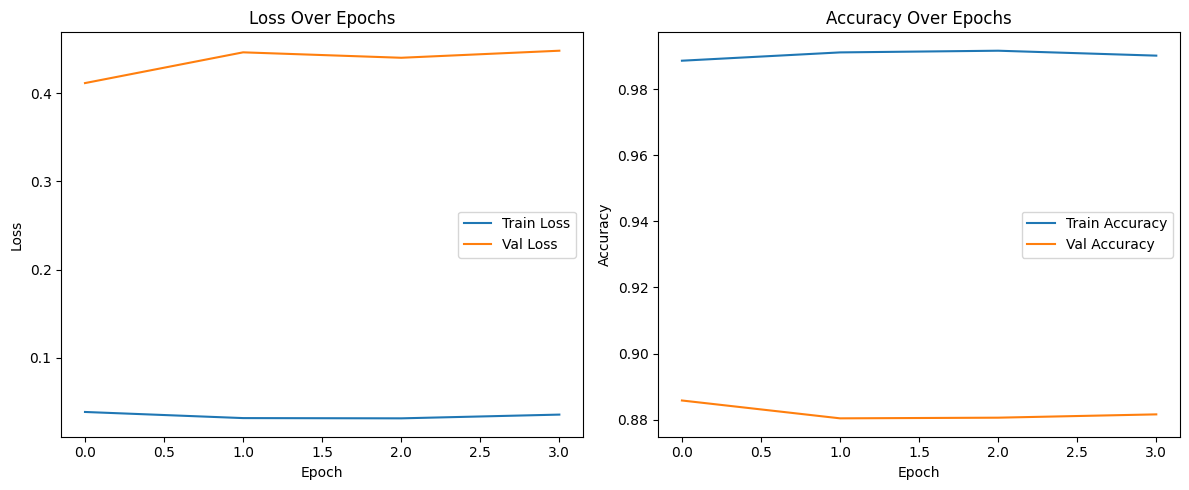

Pruned 60% : Accuracy: 87.51% | Size: 2.67 MB | Params: 700010

Applying 70% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0365 | Val Loss: 0.5035 | Train Acc: 0.9895 | Val Acc: 0.8706
Epoch 2/10 | Train Loss: 0.0351 | Val Loss: 0.4293 | Train Acc: 0.9901 | Val Acc: 0.8792
Epoch 3/10 | Train Loss: 0.0343 | Val Loss: 0.4755 | Train Acc: 0.9900 | Val Acc: 0.8684
Epoch 4/10 | Train Loss: 0.0357 | Val Loss: 0.4849 | Train Acc: 0.9894 | Val Acc: 0.8740
Epoch 5/10 | Train Loss: 0.0335 | Val Loss: 0.4517 | Train Acc: 0.9910 | Val Acc: 0.8792
Early stopping triggered.


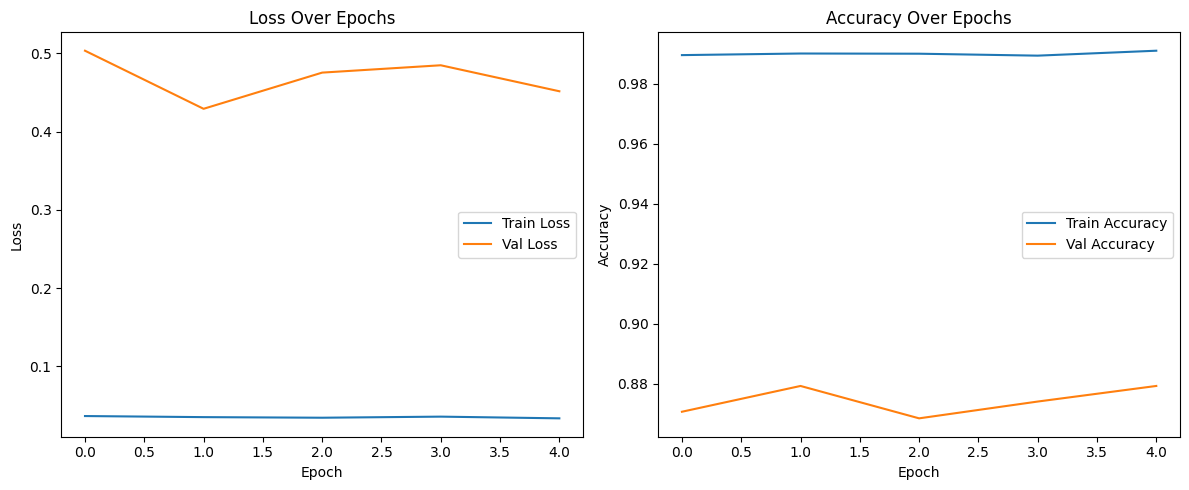

Pruned 70% : Accuracy: 87.35% | Size: 2.40 MB | Params: 630008

Applying 80% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0404 | Val Loss: 0.4380 | Train Acc: 0.9882 | Val Acc: 0.8786
Epoch 2/10 | Train Loss: 0.0359 | Val Loss: 0.4580 | Train Acc: 0.9895 | Val Acc: 0.8766
Epoch 3/10 | Train Loss: 0.0371 | Val Loss: 0.4532 | Train Acc: 0.9891 | Val Acc: 0.8748
Epoch 4/10 | Train Loss: 0.0326 | Val Loss: 0.4469 | Train Acc: 0.9909 | Val Acc: 0.8798
Early stopping triggered.


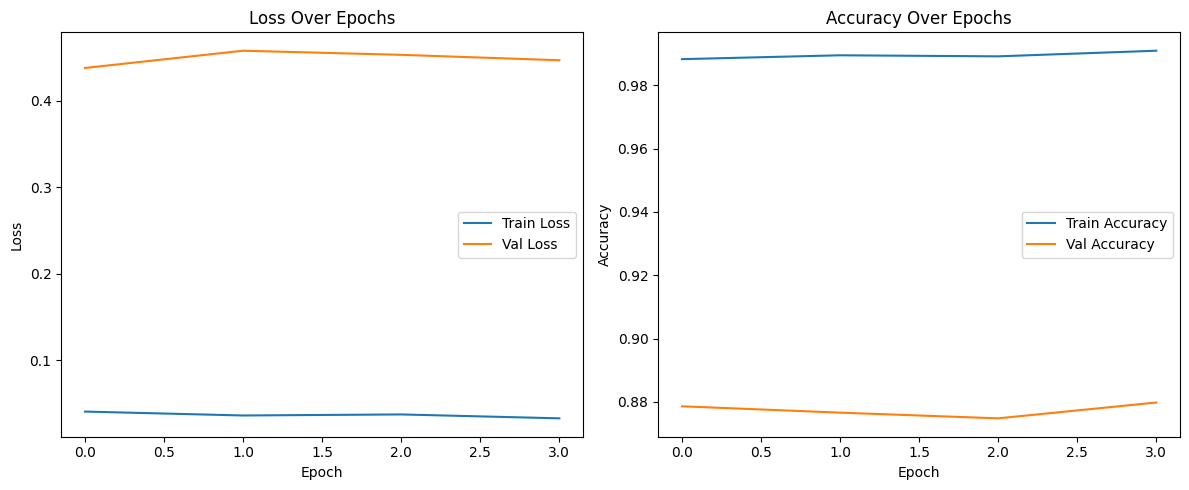

Pruned 80% : Accuracy: 87.07% | Size: 2.16 MB | Params: 567007


In [33]:
save_dir = os.path.join(base_path, 'step_by_step_pruned')
os.makedirs(save_dir, exist_ok=True)

accuracies = []
sizes_MB = []
nonzero_counts = []
pruning_percentages = []

pruning_steps = list(range(20, 90, 10))

for step in pruning_steps:
    print(f"\nApplying {step}% cumulative pruning:")

    apply_incremental_pruning(model_sbs, amount=0.1)

    model_sbs = train_model(model_sbs, train_loader, val_loader, num_epochs=10, patience=3, device=device)

    acc = evaluate(model_sbs, test_loader, device=device)
    size_mb, nonzero_params = count_nonzero_param_size_step(model_sbs)

    print(f"Pruned {step}% : Accuracy: {acc * 100:.2f}% | Size: {size_mb:.2f} MB | Params: {nonzero_params}")

    accuracies.append(acc * 100)
    sizes_MB.append(size_mb)
    nonzero_counts.append(nonzero_params)
    pruning_percentages.append(step)

    torch.save(model_sbs.state_dict(), os.path.join(save_dir, f'cnn_sbs_{step}.pth'))


##### 1: Quantize 50% Pruned

###### Quantize 8:

In [38]:
pruned_sbs50_model = CNNModel(num_classes=10)

def apply_dummy_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.identity(module, 'weight')

apply_dummy_pruning(pruned_sbs50_model)

pruned_sbs50_model.load_state_dict(
    torch.load(base_path + "/step_by_step_pruned/cnn_sbs_50.pth", map_location=torch.device(device))
)


<All keys matched successfully>

In [37]:
def remove_pruning_reparam(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            try:
                prune.remove(module, 'weight')
            except ValueError:
                pass

In [39]:
remove_pruning_reparam(pruned_sbs50_model)

In [40]:
quantized8_sbs50_model = prepare(pruned_sbs50_model, w_bits=8, a_bits=8)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.3937 | Val Loss: 0.5004 | Train Acc: 0.8650 | Val Acc: 0.8512
Epoch 2/10 | Train Loss: 0.2393 | Val Loss: 0.4588 | Train Acc: 0.9149 | Val Acc: 0.8556
Epoch 3/10 | Train Loss: 0.2031 | Val Loss: 0.4695 | Train Acc: 0.9288 | Val Acc: 0.8612
Epoch 4/10 | Train Loss: 0.1802 | Val Loss: 0.4792 | Train Acc: 0.9367 | Val Acc: 0.8504
Epoch 5/10 | Train Loss: 0.1619 | Val Loss: 0.4970 | Train Acc: 0.9429 | Val Acc: 0.8500
Epoch 6/10 | Train Loss: 0.1507 | Val Loss: 0.4829 | Train Acc: 0.9470 | Val Acc: 0.8586
Epoch 7/10 | Train Loss: 0.1234 | Val Loss: 0.4597 | Train Acc: 0.9573 | Val Acc: 0.8638
Epoch 8/10 | Train Loss: 0.1132 | Val Loss: 0.4478 | Train Acc: 0.9621 | Val Acc: 0.8662
Epoch 9/10 | Train Loss: 0.1111 | Val Loss: 0.4455 | Train Acc: 0.9629 | Val Acc: 0.8658
Epoch 10/10 | Train Loss: 0.1055 | Val Loss: 0.4339 | Train Acc: 0.9642 | Val Acc: 0.8692


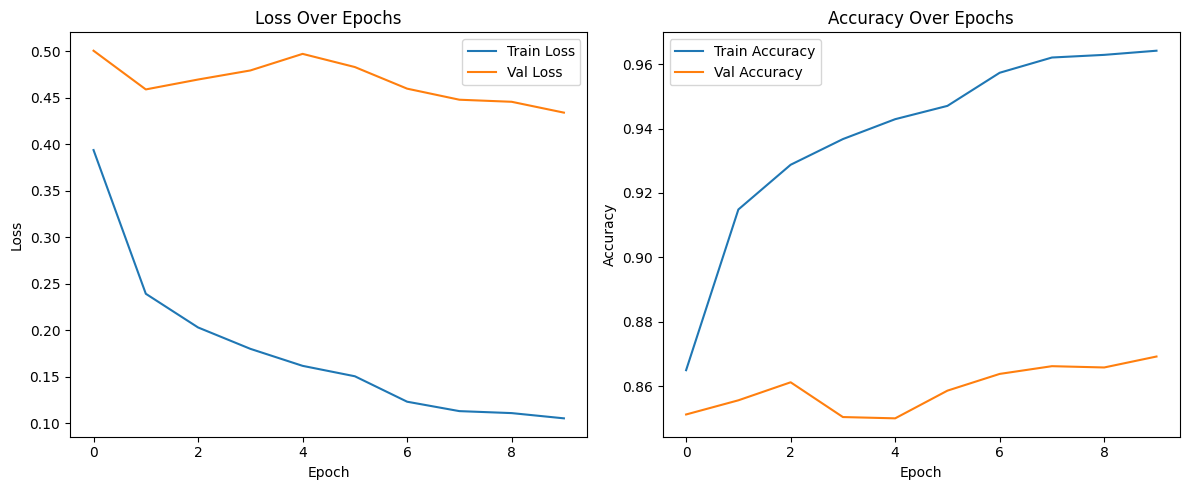

In [41]:
quantized8_sbs50_model = train_model(quantized8_sbs50_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [42]:
quant8_sbs50_acc = evaluate(quantized8_sbs50_model, test_loader, device=device)
print(f"Quantized unstructured (Step by step) 50% pruned model (8 bit) accuracy after fine-tuning: {quant8_sbs50_acc:.4f}")

Quantized unstructured (Step by step) 50% pruned model (8 bit) accuracy after fine-tuning: 0.8718


In [43]:
torch.save(quantized8_sbs50_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_sbs50_quantized8.pth")

In [44]:
report_sizes_pruned(quantized8_sbs50_model,  "8-bit QAT unstructured 50% pruned",     8)

[8-bit QAT unstructured 50% pruned] Size with 8-bit quantized weights: 1.36 MB


###### Quantize 6:

In [45]:
quantized6_sbs50_model = prepare(pruned_sbs50_model, w_bits=6, a_bits=6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4159 | Val Loss: 0.5062 | Train Acc: 0.8588 | Val Acc: 0.8434
Epoch 2/10 | Train Loss: 0.2511 | Val Loss: 0.4758 | Train Acc: 0.9112 | Val Acc: 0.8522
Epoch 3/10 | Train Loss: 0.2166 | Val Loss: 0.4649 | Train Acc: 0.9221 | Val Acc: 0.8560
Epoch 4/10 | Train Loss: 0.1837 | Val Loss: 0.5123 | Train Acc: 0.9348 | Val Acc: 0.8508
Epoch 5/10 | Train Loss: 0.1712 | Val Loss: 0.4937 | Train Acc: 0.9392 | Val Acc: 0.8552
Epoch 6/10 | Train Loss: 0.1554 | Val Loss: 0.4931 | Train Acc: 0.9451 | Val Acc: 0.8518
Epoch 7/10 | Train Loss: 0.1485 | Val Loss: 0.4623 | Train Acc: 0.9477 | Val Acc: 0.8622
Epoch 8/10 | Train Loss: 0.1333 | Val Loss: 0.4828 | Train Acc: 0.9521 | Val Acc: 0.8616
Epoch 9/10 | Train Loss: 0.1269 | Val Loss: 0.4745 | Train Acc: 0.9561 | Val Acc: 0.8564
Epoch 10/10 | Train Loss: 0.1244 | Val Loss: 0.4647 | Train Acc: 0.9573 | Val Acc: 0.8654


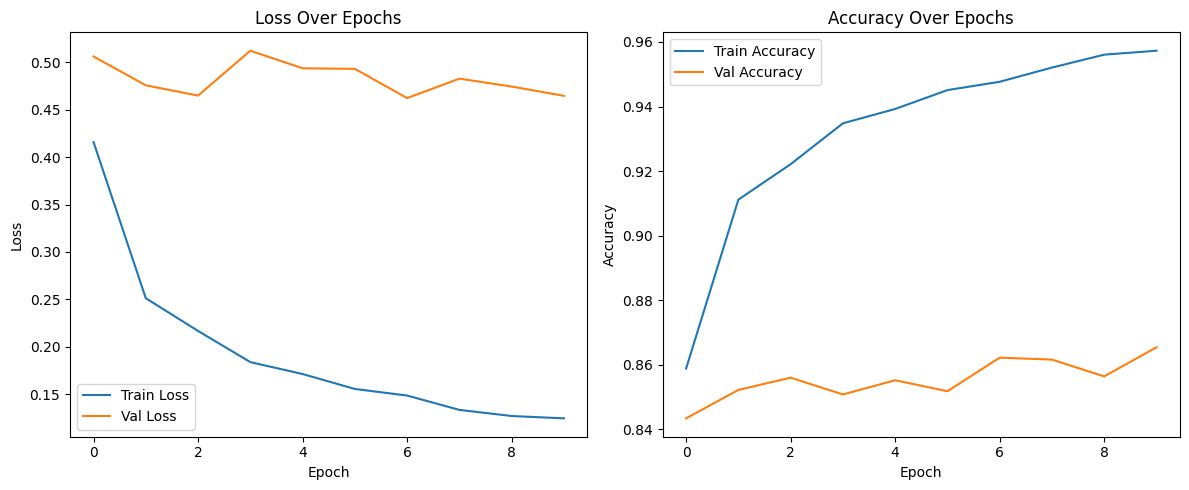

In [46]:
quantized6_sbs50_model = train_model(quantized6_sbs50_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [47]:
quant6_sbs50_acc = evaluate(quantized6_sbs50_model, test_loader, device=device)
print(f"Quantized unstructured (Step by step) 50% pruned model (6 bit) accuracy after fine-tuning: {quant6_sbs50_acc:.4f}")

Quantized unstructured (Step by step) 50% pruned model (6 bit) accuracy after fine-tuning: 0.8596


In [48]:
torch.save(quantized6_sbs50_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_sbs50_quantized6.pth")

In [49]:
report_sizes_pruned(quantized6_sbs50_model,  "6-bit QAT unstructured 50% pruned", 6)

[6-bit QAT unstructured 50% pruned] Size with 6-bit quantized weights: 1.03 MB


##### 2: Quantize 60% Pruned

###### Quantize 8:

In [50]:
pruned_sbs60_model = CNNModel(num_classes=10)

apply_dummy_pruning(pruned_sbs60_model)

pruned_sbs60_model.load_state_dict(
    torch.load(base_path + "/step_by_step_pruned/cnn_sbs_60.pth", map_location=torch.device(device))
)

<All keys matched successfully>

In [51]:
remove_pruning_reparam(pruned_sbs60_model)

In [52]:
quantized8_sbs60_model = prepare(pruned_sbs60_model, w_bits=8, a_bits=8)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.3849 | Val Loss: 0.4975 | Train Acc: 0.8679 | Val Acc: 0.8476
Epoch 2/10 | Train Loss: 0.2329 | Val Loss: 0.4705 | Train Acc: 0.9180 | Val Acc: 0.8552
Epoch 3/10 | Train Loss: 0.1902 | Val Loss: 0.4640 | Train Acc: 0.9322 | Val Acc: 0.8610
Epoch 4/10 | Train Loss: 0.1688 | Val Loss: 0.4602 | Train Acc: 0.9413 | Val Acc: 0.8592
Epoch 5/10 | Train Loss: 0.1516 | Val Loss: 0.4442 | Train Acc: 0.9474 | Val Acc: 0.8662
Epoch 6/10 | Train Loss: 0.1376 | Val Loss: 0.4623 | Train Acc: 0.9518 | Val Acc: 0.8620
Epoch 7/10 | Train Loss: 0.1301 | Val Loss: 0.4302 | Train Acc: 0.9544 | Val Acc: 0.8704
Epoch 8/10 | Train Loss: 0.1194 | Val Loss: 0.4503 | Train Acc: 0.9594 | Val Acc: 0.8648
Epoch 9/10 | Train Loss: 0.1184 | Val Loss: 0.4667 | Train Acc: 0.9584 | Val Acc: 0.8620
Epoch 10/10 | Train Loss: 0.1068 | Val Loss: 0.4429 | Train Acc: 0.9637 | Val Acc: 0.8666


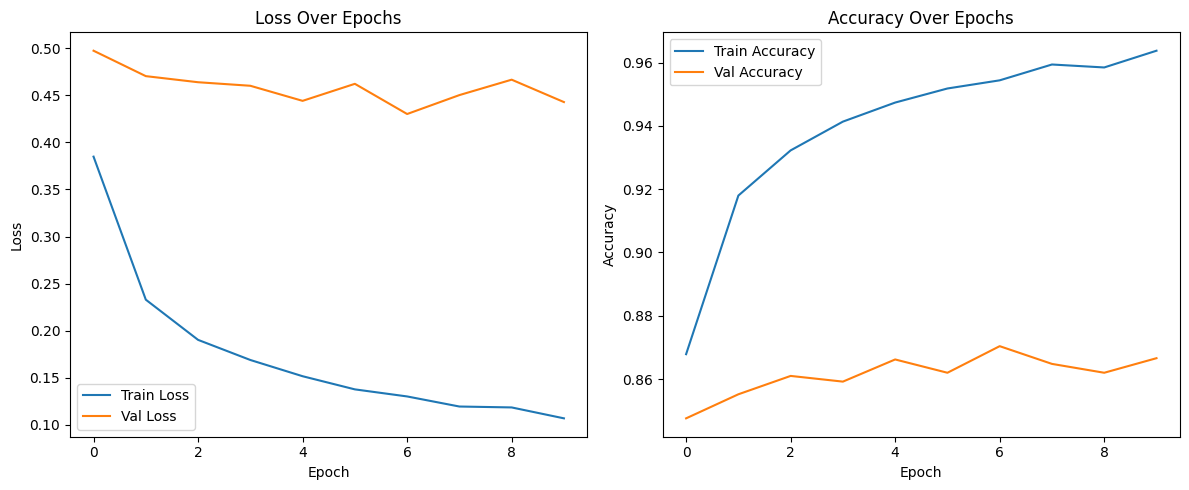

In [53]:
quantized8_sbs60_model = train_model(quantized8_sbs60_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [54]:
quant8_sbs60_acc = evaluate(quantized8_sbs60_model, test_loader, device=device)
print(f"Quantized unstructured (Step by step) 60% pruned model (8 bit) accuracy after fine-tuning: {quant8_sbs60_acc:.4f}")

Quantized unstructured (Step by step) 60% pruned model (8 bit) accuracy after fine-tuning: 0.8617


In [55]:
torch.save(quantized8_sbs60_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_sbs60_quantized8.pth")

In [56]:
report_sizes_pruned(quantized8_sbs60_model,  "8-bit QAT unstructured 60% pruned",     8)

[8-bit QAT unstructured 60% pruned] Size with 8-bit quantized weights: 1.37 MB


###### Quantize 6:

In [57]:
quantized6_sbs60_model = prepare(pruned_sbs60_model, w_bits=6, a_bits=6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4023 | Val Loss: 0.5499 | Train Acc: 0.8614 | Val Acc: 0.8364
Epoch 2/10 | Train Loss: 0.2478 | Val Loss: 0.4862 | Train Acc: 0.9127 | Val Acc: 0.8538
Epoch 3/10 | Train Loss: 0.2052 | Val Loss: 0.4648 | Train Acc: 0.9262 | Val Acc: 0.8588
Epoch 4/10 | Train Loss: 0.1805 | Val Loss: 0.4523 | Train Acc: 0.9360 | Val Acc: 0.8616
Epoch 5/10 | Train Loss: 0.1599 | Val Loss: 0.4685 | Train Acc: 0.9425 | Val Acc: 0.8600
Epoch 6/10 | Train Loss: 0.1471 | Val Loss: 0.4585 | Train Acc: 0.9489 | Val Acc: 0.8636
Epoch 7/10 | Train Loss: 0.1357 | Val Loss: 0.4557 | Train Acc: 0.9521 | Val Acc: 0.8682
Epoch 8/10 | Train Loss: 0.1252 | Val Loss: 0.4453 | Train Acc: 0.9562 | Val Acc: 0.8646
Epoch 9/10 | Train Loss: 0.1220 | Val Loss: 0.4679 | Train Acc: 0.9565 | Val Acc: 0.8636
Epoch 10/10 | Train Loss: 0.1128 | Val Loss: 0.4493 | Train Acc: 0.9609 | Val Acc: 0.8694


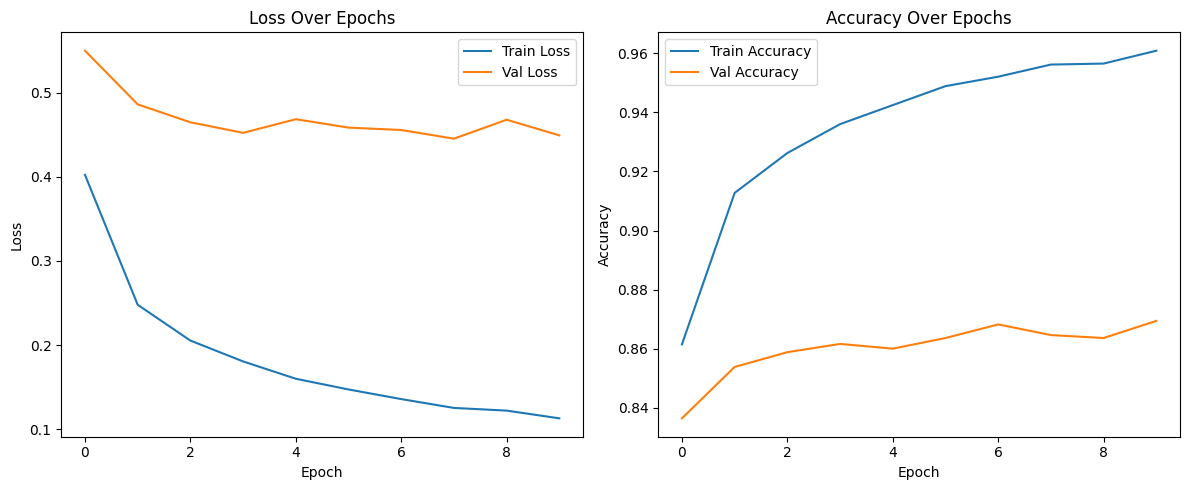

In [58]:
quantized6_sbs60_model = train_model(quantized6_sbs60_model, train_loader, val_loader, lr=0.001, num_epochs=10, device=device)

In [59]:
quant6_sbs60_acc = evaluate(quantized6_sbs60_model, test_loader, device=device)
print(f"Quantized unstructured (Step by step) 60% pruned model (6 bit) accuracy after fine-tuning: {quant6_sbs60_acc:.4f}")

Quantized unstructured (Step by step) 60% pruned model (6 bit) accuracy after fine-tuning: 0.8618


In [60]:
torch.save(quantized6_sbs60_model.state_dict(), base_path + "/pruned/unstructured/cnn_model_sbs60_quantized6.pth")

In [61]:
report_sizes_pruned(quantized6_sbs60_model,  "6-bit QAT unstructured 60% pruned", 6)

[6-bit QAT unstructured 60% pruned] Size with 6-bit quantized weights: 1.03 MB
